In [106]:
# import necessary packages
import pandas as pd
import numpy as np
from sklearn import linear_model
import seaborn as sns
from matplotlib import pyplot as plt

In [107]:
orders = pd.read_csv('./data/Orders.csv')
returns = pd.read_csv('./data/Returns.csv')

pd.set_option('display.max_columns',None)
pd.set_option('display.min_rows',0)
pd.set_option('display.max_rows',100)

## Part I: Preprocessing and EDA

- The data comes from a global e-retailer company, including orders from 2012 to 2015. Import the **Orders** dataset and do some basic EDA. 
- For problem 1 to 3, we mainly focus on data cleaning and data visualizations. You can use all the packages that you are familiar with to conduct some plots and also provide **brief interpretations** about your findings.

### Problem 1: Dataset Import & Cleaning
Check **"Profit"** and **"Sales"** in the dataset, convert these two columns to numeric type. 

In [108]:
orders.Profit = orders.Profit.replace('[\$,]', '', regex=True).astype(float)
orders.Sales = orders.Sales.replace('[\$,]', '', regex=True).astype(float)

### Problem 2: Inventory Management
- Retailers that depend on seasonal shoppers have a particularly challenging job when it comes to inventory management. Your manager is making plans for next year's inventory.
- He wants you to answer the following questions:
    1. Is there any seasonal trend of inventory in the company?
    2. Is the seasonal trend the same for different categories?

In [109]:
orders['Month'] = pd.DatetimeIndex(orders['Order.Date']).month

def month_to_season(month):
    if month in [3,4,5]:
        month = '1'  # spring
    elif month in [6,7,8]:
        month = '2'  # summer
    elif month in [9,10,11]:
        month = '3'  # fall
    else:
        month = '4'  # winter
    return(month)

orders['Season'] = orders.Month.apply(month_to_season)

In [110]:
season_quantity = orders.groupby(['Season']).agg({"Quantity": 'sum'})

In [111]:
season_quantity

,Quantity
Season,
1,34052
2,46651
3,59161
4,38448


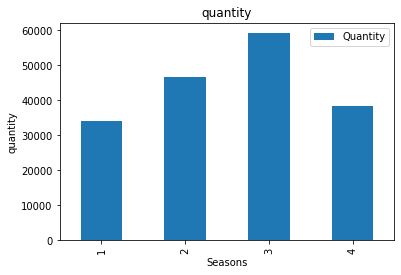

In [112]:
season_quantity.plot.bar()
plt.title('quantity')
plt.xlabel('Seasons')
plt.ylabel('quantity')
plt.show()

In [113]:
Furniture = orders["Category"]=='Furniture'
test_f = orders[Furniture]
Technology = orders["Category"]=='Technology'
test_t = orders[Technology]
Office_Supplies = orders["Category"]=='Office Supplies'
test_os = orders[Office_Supplies]

test_category = pd.DataFrame({'Office Supplies':test_os.Season.value_counts(),'Furniture': test_f.Season.value_counts(), 'Technology': test_t.Season.value_counts()})

test_category = test_category.sort_index()

test_category

,Office Supplies,Furniture,Technology
1,6054,1856,1916
2,8381,2488,2693
3,10170,3347,3308
4,6684,2169,2224


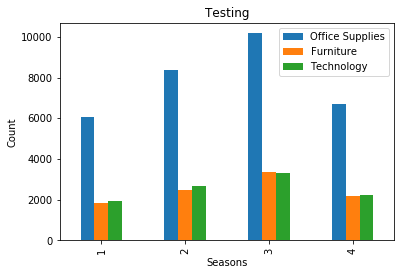

In [114]:
test_category.plot.bar()
plt.title('Testing')
plt.xlabel('Seasons')
plt.ylabel('Count')
plt.show()

Furniture category had a slight drop in sales in spring and summer, but overall all categories followed a similar trend from overall (Winter < Spring < Summer < Fall)

# Problem 3: Why Did Customers Make Returns? 

### *Question 1: How much profit did we lose due to returns each year?*

In [115]:
# merge returns and orders dataframe. Create new column year from order.date
returns = returns.rename(columns={'Order ID': 'Order.ID'})
losses = pd.merge(orders, returns, on='Order.ID')
losses['Year'] = pd.DatetimeIndex(losses['Order.Date']).year

In [116]:
# groupby year and aggregate sum of profits per year
profit_loss = losses.groupby('Year').agg({'Profit':'sum'})
profit_loss = profit_loss.rename(columns={'Profit': 'Profit Loss'})
profit_loss

,Profit Loss
Year,
2012,17477.26
2013,9269.89
2014,17510.63
2015,17112.97


Text(0.5, 1.0, 'Profit Loss Due to Returns By Year')

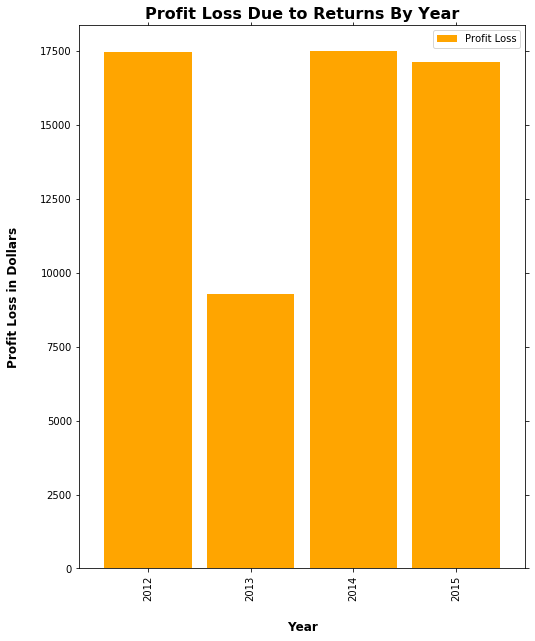

In [117]:
# plotting profit loss
loss = profit_loss.plot(kind='bar', figsize=(8, 10), color='orange', zorder=2, width=0.85)
loss.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
loss.set_xlabel("Year", labelpad=20, weight='bold', size=12)
loss.set_ylabel("Profit Loss in Dollars", labelpad=20, weight='bold', size=12)
loss.set_title("Profit Loss Due to Returns By Year", weight='bold', size=16)

### *Question 2: How many customers returned more than once? More than 5 times?*

In [118]:
return_count = losses.groupby(['Customer.ID']).agg({'Returned':'count'})

In [119]:
one = return_count[return_count > 1].dropna()
five = return_count[return_count > 5].dropna()

In [120]:
print('Number of customers who returned more than once: ',len(one.index))
print('Number of customers who returned more than five times: ',len(five.index))

Number of customers who returned more than once:  547
Number of customers who returned more than five times:  46


### *Question 3: Which regions are more likely to return orders?*

In [121]:
# merging return and orders. manipulating Returned column
or_merge = pd.merge(orders, returns,on=["Order.ID"], how="left")
or_merge['Returned'].fillna('No', inplace=True)
or_merge['Returned'] = or_merge['Returned'].map({'Yes': 1, 'No':0})

In [122]:
# aggregating return ratios per region
region_return = or_merge.groupby('Region_x').agg({'Returned':'mean'}).sort_values(by='Returned')
region_return

,Returned
Region_x,
Eastern Africa,0.024725
Central Africa,0.026439
Eastern Europe,0.027469
Central US,0.031855
Northern Europe,0.034483
Canada,0.039062
Western Europe,0.039606
North Africa,0.039906
Caribbean,0.040828


Text(0.5, 1.0, 'Number of Returned Products by Region')

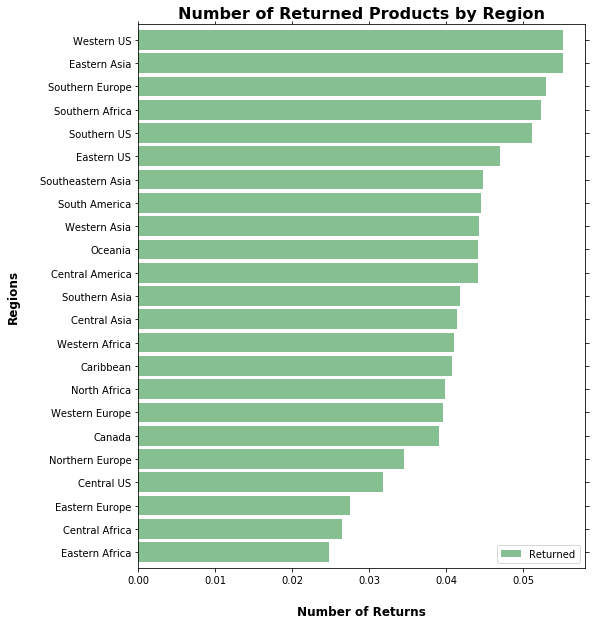

In [123]:
# plotting return ratios per region
region_fig = region_return.plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)
region_fig.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
region_fig.set_xlabel("Number of Returns", labelpad=20, weight='bold', size=12)
region_fig.set_ylabel("Regions", labelpad=20, weight='bold', size=12)
region_fig.set_title("Number of Returned Products by Region", weight='bold', size=16)

### *Question 4: Which categories (sub-categories) of products are more likely to be returned?*

In [124]:
category_return_count = losses.groupby(['Category']).agg({'Returned':'count'})
category_return_ratio = or_merge.groupby(['Category']).agg({'Returned':'mean'})

Text(0.5, 1.0, 'Number of Products Returned by Category (ratio)')

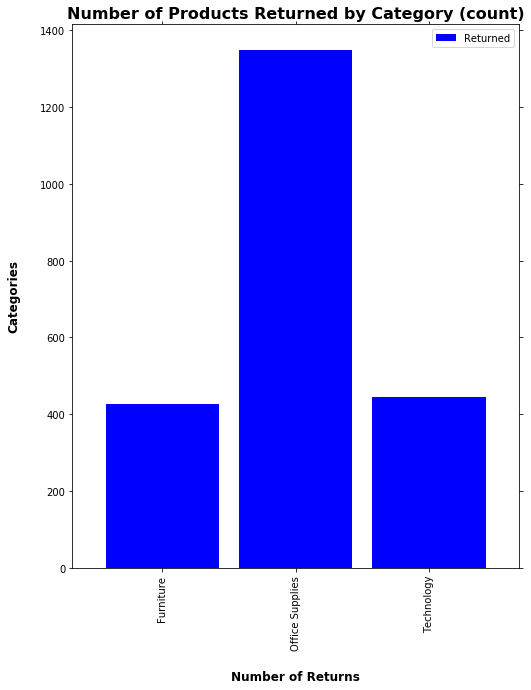

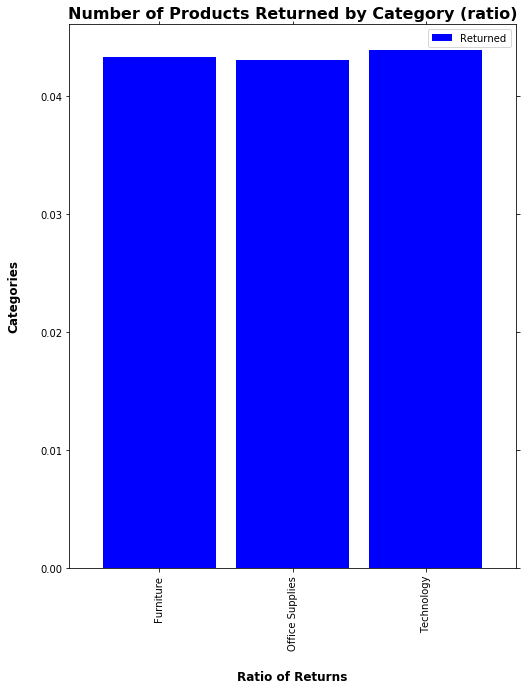

In [125]:
cat_fig = category_return_count.plot(kind='bar', figsize=(8, 10), color='blue', zorder=2, width=0.85)
cat_fig.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
cat_fig.set_xlabel("Number of Returns", labelpad=20, weight='bold', size=12)
cat_fig.set_ylabel("Categories", labelpad=20, weight='bold', size=12)
cat_fig.set_title("Number of Products Returned by Category (count)", weight='bold', size=16)

cat_fig_ratio = category_return_ratio.plot(kind='bar', figsize=(8, 10), color='blue', zorder=2, width=0.85)
cat_fig_ratio.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
cat_fig_ratio.set_xlabel("Ratio of Returns", labelpad=20, weight='bold', size=12)
cat_fig_ratio.set_ylabel("Categories", labelpad=20, weight='bold', size=12)
cat_fig_ratio.set_title("Number of Products Returned by Category (ratio)", weight='bold', size=16)

In [126]:
subcategory_return_count = losses.groupby(['Sub.Category']).agg({'Returned':'count'})
subcategory_return_count = subcategory_return_count.sort_values(by=['Returned'])

subcategory_return_ratio = or_merge.groupby('Sub.Category').agg({'Returned':'mean'})
subcategory_return_ratio = subcategory_return_ratio.sort_values(by='Returned')

Text(0.5, 1.0, 'Number of Products Returned in Each Subcatecory (ratio)')

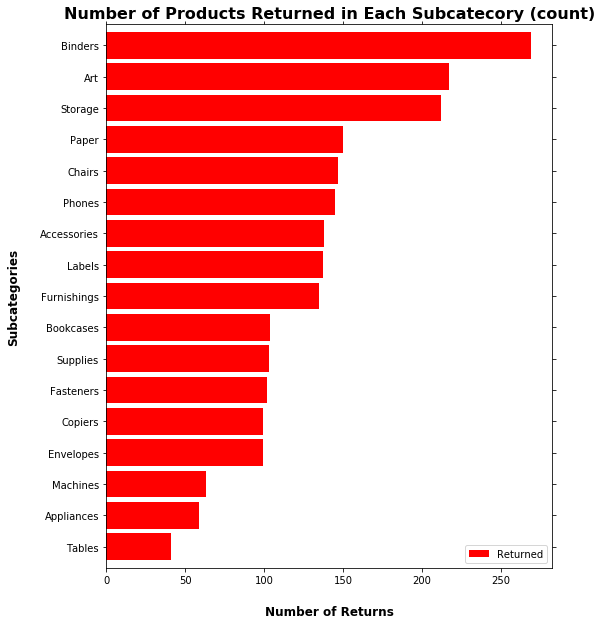

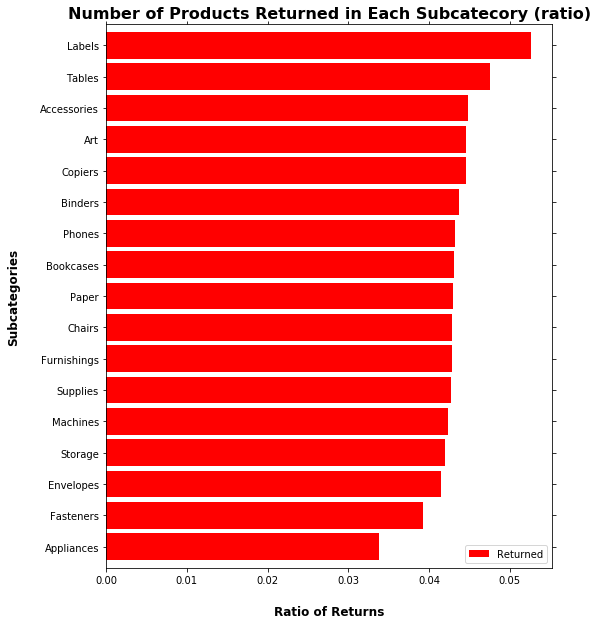

In [127]:
subcat_fig = subcategory_return_count.plot(kind='barh', figsize=(8, 10), color='red', zorder=2, width=0.85)
subcat_fig.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
subcat_fig.set_xlabel("Number of Returns", labelpad=20, weight='bold', size=12)
subcat_fig.set_ylabel("Subcategories", labelpad=20, weight='bold', size=12)
subcat_fig.set_title("Number of Products Returned in Each Subcatecory (count)", weight='bold', size=16)

subcat_fig_ratio = subcategory_return_ratio.plot(kind='barh', figsize=(8, 10), color='red', zorder=2, width=0.85)
subcat_fig_ratio.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
subcat_fig_ratio.set_xlabel("Ratio of Returns", labelpad=20, weight='bold', size=12)
subcat_fig_ratio.set_ylabel("Subcategories", labelpad=20, weight='bold', size=12)
subcat_fig_ratio.set_title("Number of Products Returned in Each Subcatecory (ratio)", weight='bold', size=16)

# Problem 4: Feature Engineering

### *Step 1: Create the Dependent Variable*

In [128]:
orders_returns = orders.merge(returns, how='left' , on= 'Order.ID')
orders_returns['Year'] = pd.DatetimeIndex(orders_returns['Order.Date']).year
orders_returns['Returned'].fillna('No', inplace=True)
orders_returns['Returned'] = orders_returns['Returned'].map({'Yes': 1, 'No':0})
orders_returns.drop('Region_y', axis=1, inplace=True)
orders_returns.rename(columns={'Region_x':'Region'}, inplace=True)

In [129]:
orders_returns.head()

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Month,Season,Returned,Year
0,40098,CA-2014-AB10015140-41954,11/11/14,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,11,3,0,2014
1,26341,IN-2014-JR162107-41675,2/5/14,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,2,4,0,2014
2,25330,IN-2014-CR127307-41929,10/17/14,10/18/14,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,10,3,0,2014
3,13524,ES-2014-KM1637548-41667,1/28/14,1/30/14,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,1,4,0,2014
4,47221,SG-2014-RH9495111-41948,11/5/14,11/6/14,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,11,3,0,2014


### *Step 2: New Feature - Process.Time*

In [130]:
orders_returns['Order.Date'] = pd.to_datetime(orders_returns['Order.Date'])
orders_returns['Ship.Date'] = pd.to_datetime(orders_returns['Ship.Date'])
orders_returns['Process.Time'] = orders_returns['Ship.Date']-orders_returns['Order.Date']
orders_returns['Process.Time'] = orders_returns['Process.Time'].dt.days

### *Step 3: How many times product has been returned*

In [147]:
product_returns = orders_returns.groupby('Product.ID').agg({'Returned':'sum'})
return_count = orders_returns.merge(product_returns, how = 'left', on = 'Product.ID').Returned_y
orders_returns['Returned.Count'] = return_count

In [148]:
orders_returns.head()

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Month,Season,Returned,Year,Process.Time,Returned.Count
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,11,3,0,2014,2,0
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,2,4,0,2014,2,2
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,10,3,0,2014,1,2
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,1,4,0,2014,2,0
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,11,3,0,2014,1,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B25E8B1E08>]],
      dtype=object)

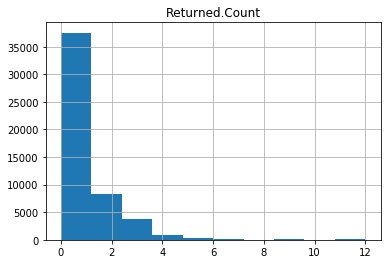

In [237]:
orders_returns[['Returned.Count']].hist()

# Problem 5: Fitting Models

- You can use any binary classification method you have learned so far.
- Use 80/20 training and test splits to build your model. 
- Double check the column types before you fit the model.
- Only include useful features. i.e all the `ID`s should be excluded from your training set.
- Note that there are only less than 5% of the orders have been returned, so you should consider using the [createDataPartition](https://www.rdocumentation.org/packages/caret/versions/6.0-80/topics/createDataPartition) function from `caret` package and [StratifiedKfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn-model-selection-stratifiedkfold) from sklearn when running cross-validation.
- Do forget to `set.seed()` before the spilt to make your result reproducible.
- **Note:** We are not looking for the best tuned model in the lab so don't spend too much time on grid search. Focus on model evaluation and the business use case of each model.

In [155]:
from sklearn.linear_model import LogisticRegression
import random

In [149]:
Y = orders_returns.Returned
X = orders_returns[['Process.Time', 'Returned.Count']]

In [150]:
X.head()

,Process.Time,Returned.Count
0,2,0
1,2,2
2,1,2
3,2,0
4,1,0


In [171]:
log_model = LogisticRegression(C=1e4, class_weight='balanced')
log_model.fit(X, Y)
print('The logistic model accuracy is:')
print(log_model.score(X, Y))
print('The base model accuracty is:')
print('0.5000')
print('The ratio of returns is:')
print(1 - np.sum(Y)/len(Y))

The logistic model accuracy is:
0.39861571456424255
The base model accuracty is:
0.5000
The ratio of returns is:
0.956716708910119


### Problem 6: Evaluating Models
- What is the best metric to evaluate your model. Is accuracy good for this case?
- Now you have multiple models, which one would you pick? 
- Can you get any clue from the confusion matrix? What is the meaning of precision and recall in this case? Which one do you care the most? How will your model help the manager make decisions?
- **Note:** The last question is open-ended. Your answer could be completely different depending on your understanding of this business problem.


In [178]:
orders_returns.columns

Index(['Row.ID', 'Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode',
       'Customer.ID', 'Customer.Name', 'Segment', 'Postal.Code', 'City',
       'State', 'Country', 'Region', 'Market', 'Product.ID', 'Category',
       'Sub.Category', 'Product.Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping.Cost', 'Order.Priority', 'Month', 'Season',
       'Returned', 'Year', 'Process.Time', 'Returned.Count'],
      dtype='object')

In [186]:
X = orders_returns[['Process.Time']]

log_model = LogisticRegression(C=1e4, class_weight='balanced')
log_model.fit(X, Y)
print('The logistic model accuracy is:')
print(log_model.score(X, Y))
print('The base model accuracty is:')
print('0.5000')

The logistic model accuracy is:
0.33501657243127314
The base model accuracty i:
0.5000


In [198]:
X = orders_returns[['Sales']]

log_model = LogisticRegression(C=1e4, class_weight='balanced')
log_model.fit(X, Y)
print('accuracy: ', log_model.score(X, Y))
print('coeficients :', log_model.coef_)
print('feature columns: ', X.columns)
print('intercept: ',log_model.intercept_)

accuracy:  0.956716708910119
coeficients : [[-3.4907895e-05]]
feature columns:  Index(['Sales'], dtype='object')
intercept:  [5.96817026e-08]


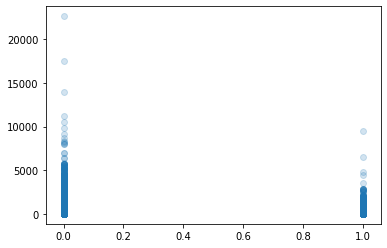

In [195]:
plt.scatter(orders_returns['Returned'], orders_returns['Sales'], alpha=.2)

In [200]:
X = orders_returns[['Returned.Count']]

log_model = LogisticRegression(C=1e4, class_weight='balanced')
log_model.fit(X, Y)
print('accuracy: ', log_model.score(X, Y))
print('coeficients :', log_model.coef_)
print('feature columns: ', X.columns)
print('intercept: ',log_model.intercept_)

accuracy:  0.7366348216026516
coeficients : [[0.73545453 0.01766904]]
feature columns:  Index(['Returned.Count', 'Process.Time'], dtype='object')
intercept:  [-1.09670138]


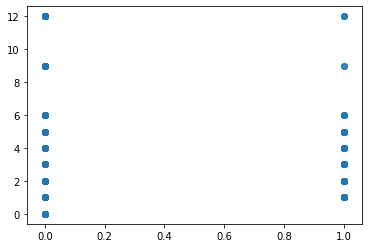

In [196]:
plt.scatter(orders_returns['Returned'], orders_returns['Returned.Count'], alpha=.2)

In [201]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y, log_model.predict(X))

array([[36552, 12518],
       [  990,  1230]], dtype=int64)


### Problem 7: Feature Engineering Revisit
- Is there anything wrong with the new feature we generated? How should we fix it?
- ***Hint***: For the real test set, we do not know it will get returned or not.

In [227]:
product_returns = orders_returns.groupby('Product.ID').agg({'Returned':('count', 'sum')})
product_returns['Return.Ratio'] = product_returns['Returned']['sum'] /product_returns['Returned']['count']
product_returns = product_returns['Return.Ratio']
product_returns
orders_returns = orders_returns.merge(product_returns, how = 'left', on = 'Product.ID')

In [228]:
orders_returns

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Month,Season,Returned,Year,Process.Time,Returned.Count,Return.Ratio
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.00,62.15,40.770,High,11,3,0,2014,2,0,0.000000
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.10,-288.77,923.630,Critical,2,4,0,2014,2,2,0.080000
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.10,919.97,915.490,Medium,10,3,0,2014,1,2,0.083333
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.10,-96.54,910.160,Medium,1,4,0,2014,2,0,0.000000
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.00,311.52,903.040,Critical,11,3,0,2014,1,0,0.000000
5,22732,IN-2014-JM156557-41818,2014-06-28,2014-07-01,Second Class,JM-156557,Jim Mitchum,Corporate,NaN,Sydney,New South Wales,Australia,Oceania,Asia Pacific,TEC-PH-5842,Technology,Phones,"Samsung Smart Phone, with Caller ID",2862.68,5,0.10,763.28,897.350,Critical,6,2,0,2014,3,1,0.066667
6,30570,IN-2012-TS2134092-41219,2012-11-06,2012-11-08,First Class,TS-2134092,Toby Swindell,Consumer,NaN,Porirua,Wellington,New Zealand,Oceania,Asia Pacific,FUR-CH-5378,Furniture,Chairs,"Novimex Executive Leather Armchair, Adjustable",1822.08,4,0.00,564.84,894.770,Critical,11,3,0,2012,2,5,0.128205
7,31192,IN-2013-MB1808592-41378,2013-04-14,2013-04-18,Standard Class,MB-1808592,Mick Brown,Consumer,NaN,Hamilton,Waikato,New Zealand,Oceania,Asia Pacific,FUR-TA-3764,Furniture,Tables,"Chromcraft Conference Table, Fully Assembled",5244.84,6,0.00,996.48,878.380,High,4,1,0,2013,4,0,0.000000
8,40099,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,FUR-BO-5957,Furniture,Bookcases,"Sauder Facets Collection Library, Sky Alder Fi...",341.96,2,0.00,54.71,25.270,High,11,3,0,2014,2,0,0.000000
9,36258,CA-2012-AB10015140-40974,2012-03-06,2012-03-07,First Class,AB-100151404,Aaron Bergman,Consumer,98103.0,Seattle,Washington,United States,Western US,USCA,FUR-CH-4421,Furniture,Chairs,"Global Push Button Manager's Chair, Indigo",48.71,1,0.20,5.48,11.130,High,3,1,0,2012,1,1,0.111111


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B25EBBCC48>]],
      dtype=object)

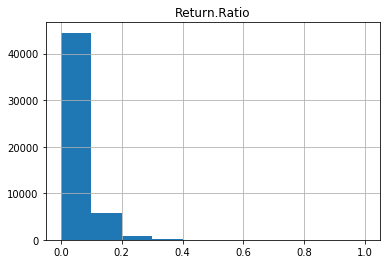

In [239]:
orders_returns[['Return.Ratio']].hist()

In [233]:
X = orders_returns[['Return.Ratio']]

np.random.seed(100)
log_model = LogisticRegression(C=1e4, class_weight='balanced')
log_model.fit(X, Y)
print('accuracy: ', log_model.score(X, Y))
print('coeficients :', log_model.coef_)
print('feature columns: ', X.columns)
print('intercept: ',log_model.intercept_)

accuracy:  0.7795671670891012
coeficients : [[22.83134029]]
feature columns:  Index(['Return.Ratio'], dtype='object')
intercept:  [-1.52523074]


In [238]:
confusion_matrix(Y, log_model.predict(X))

array([[37786, 11284],
       [  744,  1476]], dtype=int64)